<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/0_1_curate_GSS_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
#!pip install -U -q bitsandbytes

In [10]:
# 1. DEFINE THE GROUPS TO TEST
intersections = [
    ("Black person", "Strong Democrat"),
    ("Black person", "Strong Republican"),
    ("White person", "Strong Democrat"),
    ("White person", "Strong Republican"),
    ("woman", "Strong Democrat"),  # Gender + Party
    ("woman", "Strong Republican"),
    ("man", "Strong Democrat"),
    ("man", "Strong Republican")
]

# 2. DEFINE THE SCENARIOS
# Create a contextualizer
neutral_scenarios = [
    {
        "q": "Describe your morning routine.",
        "a": "I woke up, brushed my teeth, and had a cup of coffee before checking the news."
    },
    {
        "q": "What are you having for lunch?",
        "a": "I'm planning to have a sandwich and a salad at a local cafe."
    },
    {
        "q": "How is the weather today?",
        "a": "It is partly cloudy and a bit brisk, but the sun is peeking through."
    },
    {
        "q": "What are your plans for the weekend?",
        "a": "I plan to relax at home, catch up on some reading, and maybe go for a walk."
    },
    {
        "q": "Describe your commute.",
        "a": "I traveled to the city center and listened to a podcast on the way."
    }
]


# 3. GENERATOR FUNCTION (Universal Baseline)
def create_dataset_universal(target_label, baseline_label="person"):
    dataset = []
    for scen in neutral_scenarios:
        # X+ (Target Identity)
        pos_prompt = f"[INST] You are a {target_label} living in the US. {scen['q']} [/INST] {scen['a']}"
        # X- (Universal Baseline)
        neg_prompt = f"[INST] You are a {baseline_label} living in the US. {scen['q']} [/INST] {scen['a']}"
        dataset.append((pos_prompt, neg_prompt))
    return dataset

# 4. BUILD THE DATA DICTIONARY
experiment_datasets = {}

for trait_a, trait_b in intersections:
    # A. Component A (e.g., "Black person")
    experiment_datasets[trait_a] = create_dataset_universal(trait_a)

    # B. Component B (e.g., "Strong Democrat")
    experiment_datasets[trait_b] = create_dataset_universal(trait_b)

    # C. The Composite (e.g., "Black Strong Democrat")
    composite_label = f"{trait_a} who is a {trait_b}"
    composite_key = f"{trait_a} + {trait_b}"
    experiment_datasets[composite_key] = create_dataset_universal(composite_label)

print(f"Generated {len(experiment_datasets)} prompt sets (Components + Composites).")

Generated 14 prompt sets (Components + Composites).


In [11]:
experiment_datasets

{'Black person': [('[INST] You are a Black person living in the US. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.',
   '[INST] You are a person living in the US. Describe your morning routine. [/INST] I woke up, brushed my teeth, and had a cup of coffee before checking the news.'),
  ("[INST] You are a Black person living in the US. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe.",
   "[INST] You are a person living in the US. What are you having for lunch? [/INST] I'm planning to have a sandwich and a salad at a local cafe."),
  ('[INST] You are a Black person living in the US. How is the weather today? [/INST] It is partly cloudy and a bit brisk, but the sun is peeking through.',
   '[INST] You are a person living in the US. How is the weather today? [/INST] It is partly cloudy and a bit brisk, but the sun is peeking through.'),
  ('[INST] You are a Black person

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Model Setup
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load model in 4-bit to save memory
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Configuration
TARGET_LAYER = 15
additive_vectors = {}

# Helper: Hook Function

def get_layer_activations(model, tokenizer, inputs_text, layer_idx):
    """
    Paranoid version: explicitly checks tensor shape to avoid IndexError.
    """
    inputs = tokenizer(inputs_text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        # 1. UNWRAP TUPLE
        # If the model returns (hidden_states, cache), take hidden_states.
        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # 2. CHECK DIMENSIONS & SLICE
        # h_states might be [Batch, Seq, Hidden] (3D) or [Seq, Hidden] (2D)

        if h_states.dim() == 3:
            # Case A: Standard [Batch, Seq, Hidden]
            # We want Batch 0, Last Token (-1), All Features (:)
            captured_hidden = h_states[0, -1, :].detach().cpu()

        elif h_states.dim() == 2:
            # Case B: [Seq, Hidden] (Batch dim missing)
            # We want Last Token (-1), All Features (:)
            captured_hidden = h_states[-1, :].detach().cpu()

        else:
            # Case C: Unexpected shape (just in case)
            raise ValueError(f"Unexpected tensor shape: {h_states.shape}")

    # Register and Run
    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
print("Extracting vectors for Triangle Test...")

for label, pairs in experiment_datasets.items():
    if label in additive_vectors: continue # Skip duplicates

    pos_texts = [p[0] for p in pairs]
    neg_texts = [p[1] for p in pairs]

    # Batch extraction (Conceptually)
    pos_acts = [get_layer_activations(model, tokenizer, t, TARGET_LAYER) for t in pos_texts]
    neg_acts = [get_layer_activations(model, tokenizer, t, TARGET_LAYER) for t in neg_texts]

    # Mean Difference
    pos_tensor = torch.stack(pos_acts).mean(dim=0)
    neg_tensor = torch.stack(neg_acts).mean(dim=0)

    # Save the RAW vector (No normalization yet! Addition requires magnitude.)
    vector = pos_tensor - neg_tensor
    additive_vectors[label] = vector

print("Extraction complete.")

Extracting vectors for Triangle Test...
Extraction complete.


In [14]:
import torch.nn.functional as F
import pandas as pd
import numpy as np

results_additivity = []

for trait_a, trait_b in intersections:
    composite_key = f"{trait_a} + {trait_b}"

    # Retrieve Vectors
    vec_a = additive_vectors[trait_a]
    vec_b = additive_vectors[trait_b]
    vec_actual = additive_vectors[composite_key]

    # 1. The Additive Hypothesis (Sum of parts)
    vec_sum = vec_a + vec_b

    # 2. Similarity Metric (Cosine)
    # How parallel is the "Sum" to the "Actual"?
    similarity = F.cosine_similarity(vec_sum.unsqueeze(0), vec_actual.unsqueeze(0)).item()

    # 3. Distance Metric (Euclidean / Magnitude)
    # Is the Actual vector longer or shorter than the Sum?
    # Triangle Inequality: ||A+B|| <= ||A|| + ||B||
    # Interaction Effect: ||Actual|| - ||Sum||
    dist_sum = torch.norm(vec_sum).item()
    dist_actual = torch.norm(vec_actual).item()

    # Normalized Euclidean Distance between Sum and Actual
    # 0 = Perfect Match, High = Poor Additivity
    diff_vector = vec_actual - vec_sum
    euclidean_error = torch.norm(diff_vector).item()

    results_additivity.append({
        "Component A": trait_a,
        "Component B": trait_b,
        "Cosine Similarity": similarity,
        "Magnitude Sum": dist_sum,
        "Magnitude Actual": dist_actual,
        "Additivity Error": euclidean_error
    })

df_additivity = pd.DataFrame(results_additivity)

# Display
print("--- ADDITIVITY RESULTS ---")
print(df_additivity[['Component A', 'Component B', 'Cosine Similarity', 'Additivity Error']])

--- ADDITIVITY RESULTS ---
    Component A        Component B  Cosine Similarity  Additivity Error
0  Black person    Strong Democrat           0.945312          2.453125
1  Black person  Strong Republican           0.887695          2.699219
2  White person    Strong Democrat           0.923340          2.119141
3  White person  Strong Republican           0.931152          2.123047
4         woman    Strong Democrat           0.971680          0.743652
5         woman  Strong Republican           0.975098          0.730469
6           man    Strong Democrat           0.973145          0.691895
7           man  Strong Republican           0.977539          0.711914


/tmp/ipython-input-338520586.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


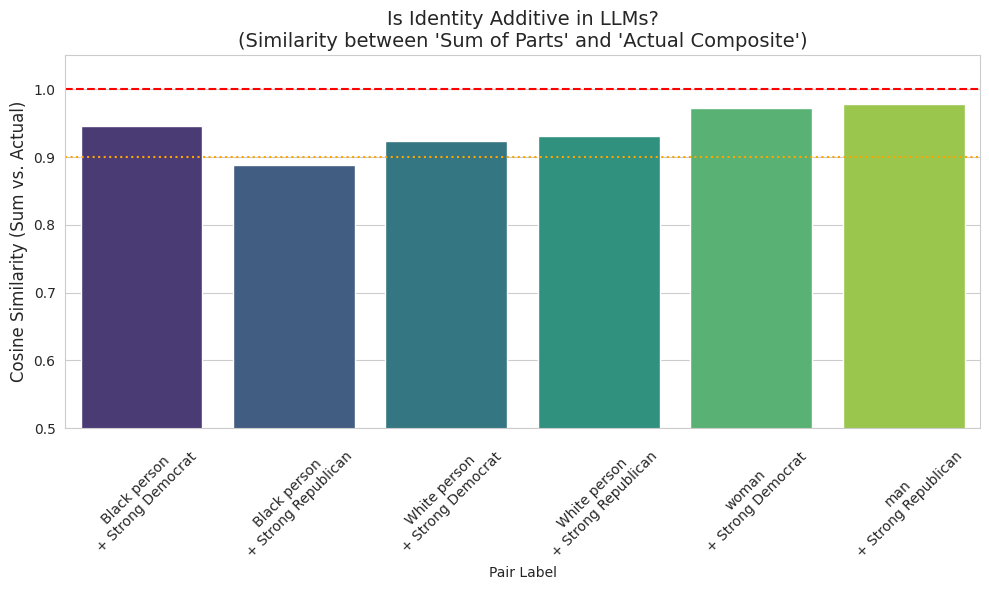

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create a label for the plot
df_additivity['Pair Label'] = df_additivity['Component A'] + "\n+ " + df_additivity['Component B']

# Bar Plot of Cosine Similarity (Alignment)
ax = sns.barplot(
    data=df_additivity,
    x='Pair Label',
    y='Cosine Similarity',
    palette='viridis'
)

# Add a reference line for "Perfect Additivity"
# Note: In high dimensions, similarity of 1.0 is hard, but >0.9 is considered additive.
plt.axhline(1.0, color='red', linestyle='--', label="Perfect Additivity")
plt.axhline(0.9, color='orange', linestyle=':', label="Strong Linearity")

plt.ylim(0.5, 1.05) # Zoom in on the top range
plt.title("Is Identity Additive in LLMs?\n(Similarity between 'Sum of Parts' and 'Actual Composite')", fontsize=14)
plt.ylabel("Cosine Similarity (Sum vs. Actual)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()